<a href="https://colab.research.google.com/github/abhionic/transformer/blob/main/transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

Adapted from The TensorFlow Authors (Copyright 2022). Modified tokenizer and inference.

### Neural machine translation with Transfomer
Neural networks for machine translation typically contain an encoder reading the input sequence and generating a representation of it. A decoder then generates the sentence word by word while consulting the representation generated by the encoder. The transformer starts by generating intial representations, or embeddings, for each word... Then, using self-attention, it aggregates information from all of the other words, generating a new representation per word informed by the entire context, represented by the filled balls. This step is then repeated multiple times in parallel for all words, successfully generating new representations. [Google AI Blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html).
<img src="https://www.tensorflow.org/images/tutorials/transformer/apply_the_transformer_to_machine_translation.gif" alt="Applying the Transformer to machine translation">

Transformer is identical to encoder-decoder RNN model, with the RNN layers replaced by self-attention layers.
<table>
<tr>
  <th>The <a href=https://www.tensorflow.org/text/tutorials/nmt_with_attention>RNN+Attention model</a></th>
  <th>A 1-layer transformer</th>
</tr>
<tr>
  <td>
   <img width=411 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention-words.png"/>
  </td>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>
Transformers excel at modeling sequential data, and layer outputs can be computed in parallel. Unlinke RNNs or CNNs where information needs to pass through many processing steps to move long distance, transformers can capture distant or long-range contexts and dependencies in the data between input or output sequences. Attention allows each location to have access to the entire input at each layer. Transformers make no assumptions about the temporal/spatial relationships across the data.

In [ ]:
# import tfds for loading data and text for text processing
!pip install tensorflow-text
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_text as tf_text
import numpy as np
import matplotlib.pyplot as plt
import time; import logging

### Data handling

In [ ]:
# dataset contains 52k training, 1.2k validation, 1.8k test examples
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               with_info=True, as_supervised=True)
train_ex, val_ex = examples['train'], examples['validation']

In [ ]:
# shuffle the tf.data.Dataset of strings and batch them efficiently
buffer_size = 20000; batch_size = 64
train_raw = (train_ex.shuffle(buffer_size).batch(batch_size)
                      .prefetch(tf.data.AUTOTUNE))
val_raw = (val_ex.shuffle(buffer_size).batch(batch_size)
                      .prefetch(tf.data.AUTOTUNE))

In [ ]:
# standardization by unicode normalization
def tf_lower_and_split_punct(text):
  # split accented characters
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # keep space, a to z, and select punctuation
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]','')
  # add spaces around punctuation
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # strip whitespace
  text = tf.strings.strip(text)
  # add start and end token to each sentence
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [ ]:
# vectorize: extract vocabulary and convert input text to sequence of tokens
max_vocab_size = 8000
context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size, ragged=True) #output_sequence_length
context_text_processor.adapt(train_raw.map(lambda context, target: context))

target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size, ragged=True)
target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '.', '[START]', '[END]', ',', 'the', 'and', 'to', 'of']

This setup is called teacher forcing because regardless of the model's output at each timestep, it gets the true value as input for the next timestep. It's efficient because the outputs ar the different sequence locations can be computed in parallel.

In [ ]:
# process dataset of strings into 0-padded tensors of token IDs
# inputs are (context, target_in) and labels are target_out (shifted by 1)
max_tokens=128
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  context = context[:, :max_tokens] # trim
  target = target_text_processor(target)
  target = target[:, :(max_tokens+1)]
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out

train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

for (pt, en), en_lbl in train_ds.take(1):
  print(pt[0, :10].numpy()); # word → id
  print(en[0, :10].numpy()); print(en_lbl[0, :10].numpy())
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[pt[0, :10].numpy()]; ' '.join(tokens) # id → word

[   4    6 2355    9  172   70   61    7  245    2]
[  3   7  13  18 599  11  86 104  24 509]
[  7  13  18 599  11  86 104  24 509   2]


'[START] e visivel que algumas coisas estao a acontecer .'

### The components
<table>
<tr>
  <th colspan=1>The original Transformer diagram</th>
  <th colspan=1>A representation of a 4-layer Transformer</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png"/>
  </td>
  <td>
   <img width=307 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-4layer-compact.png"/>
  </td>
</tr>
</table>

### The embedding and positional encoding layer
<table>
<tr>
  <th colspan=1>The embedding and positional encoding layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/PositionalEmbedding.png"/>
  </td>
</tr>
</table>
The attention layers see their input as a sequence of vectors, it needs some way to identify word order. A Transformer adds a Position Encoding to the embedding vectors. It uses a set of sines and cosines at different frequencies (across the sequence). By definition, nearby elements will have similar position encodings.

$$PE_{(pos,2i)} = \sin(pos/10000^{2i/d_{model}})$$

$$PE_{(pos,2i+1)} = \cos(pos/10000^{2i/d_{model}})$$

In [ ]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]   # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth # (1, depth)

  angle_rates = 1/(10000**depths)       # (1, depth)
  angle_rads = positions * angle_rates  # (pos, depth)

  pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)], axis=-1)
  return tf.cast(pos_encoding, dtype=tf.float32)

Ths position encoding function is a stack of sines and cosines that vibrate at different frequencies depending on their location along the depth of the embedding vector. They vibrate across the poisition axis.

(2048, 512)


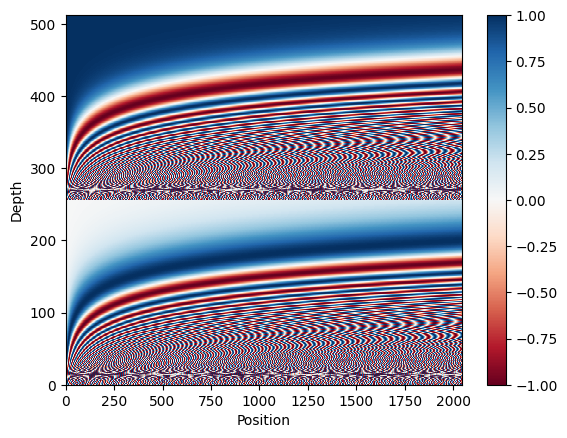

In [ ]:
pos_encoding = positional_encoding(length=2048, depth=512)
print(pos_encoding.shape) # check the shape
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu') # plot the dimensions
plt.ylabel('Depth'); plt.xlabel('Position'); plt.colorbar(); plt.show()

By definition, these vectors align well with nearby vectors along the position axis. Below the position vectos are normalized and the vector from position 1000 is compared , by dot product, to all others.

(0.0, 1.0)

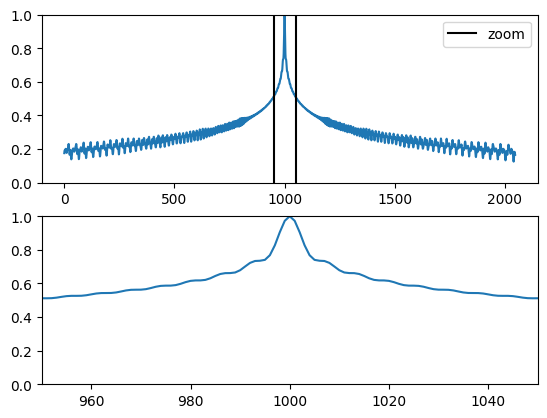

In [ ]:
pos_encoding /= tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum('pd,d -> p', pos_encoding, p)
plt.subplot(2,1,1); plt.plot(dots); plt.ylim([0,1])
plt.plot([950,950,float('nan'),1050,1050], [0,1,float('nan'),0,1],
         color='k', label='zoom'); plt.legend()
plt.subplot(2,1,2); plt.plot(dots); plt.xlim([950,1050]); plt.ylim([0,1])

Use this to create a PositionEmbedding layer that looks-up a token's embedding vector and adds the position vector.

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # this factor sets the relative scale of the embedding and positional_encoding
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [ ]:
embed_pt = PositionalEmbedding(vocab_size=context_text_processor.vocabulary_size(), d_model=512)
embed_en = PositionalEmbedding(vocab_size=target_text_processor.vocabulary_size(), d_model=512)
pt_emb = embed_pt(pt); en_emb = embed_en(en); en_emb._keras_mask

<tf.Tensor: shape=(64, 69), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ..., False, False, False]])>

### Add and normalize
<table>
<tr>
  <th colspan=2>Add and normalize</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Add+Norm.png"/>
  </td>
</tr>
</table>
The residual connection provides a direct path for the gradient (and ensures that vectors are updated by the attention layers instead of replaced), while the normalization maintains a reasonable scale for the outputs.

### The base attention layer
<table>
<tr>
  <th colspan=2>The base attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/BaseAttention.png"/>
  </td>
</tr>
</table>
Attention base class contains the component layers of MultiHeadAttention, LayerNormalization and Add. Each use-case will be implemented as subclass

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

Attention refresher - there are two inputs:
1. The query sequence, the sequence being processed, the sequence doing the attending (bottom).
2. The context sequence, the sequence being attended to (left).
<table>
<tr>
  <th>The cross attention layer</th>
  <th>Each query sees the whole context</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new-full.png"/>
  </td>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new.png"/>
  </td>
</tr>
</table>
The output has the same shape as the query-sequence. Attention layer combines the query and key vectors to determine how well they match i.e. the attention score. The layer returns the average across all the values, weighted by the attention scores. It does a fuzzy, differentiable, vectorized dictionary lookup.

### The cross attention layer
This at the center of Transformer connects the encoder and decoder.
<table>
<tr>
  <th colspan=1>The cross attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention.png"/>
  </td>
</tr>
</table>
To implement this, pass the target sequence x as the query and the context sequence as the key/value when calling the mha layer. The mha contains Dense layers to project the input vectors before using them.

In [ ]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(query=x, key=context, value=context,
                                        return_attention_scores=True)
    # cache the attention scores for plotting later
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
# test run on sample inputs
ca = CrossAttention(num_heads=2, key_dim=512) # d_model
print(pt_emb.shape); print(en_emb.shape); print(ca(en_emb, pt_emb).shape)

(64, 52, 512)
(64, 49, 512)
(64, 49, 512)


### The global self attention layer
This layer is responsible for processing the context sequence, and propagating information along it's length.
<table>
<tr>
  <th colspan=1>The global self attention layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention.png"/>
  </td>
</tr>
</table>
RNNs and CNNs have their limitations:

* In RNN information flows sequentially (limiting gradient flow).
* In CNN the receptive field grows linearly with number of layers (requires many layers). Wavenet reduces this problem by using dilated convolutions.
<table>
<tr>
  <th>Bidirectional RNN</th>
  <th>CNN</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/RNN-bidirectional.png"/>
  </td>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/CNN.png"/>
  </td>
</tr>
</table>
The global attention later lets every sequence element directly access every other sequence element, with only a few operations, and all the outputs can be computed in parallel. To implement this, pass the context sequence x, as both the query and value arguments to the mha layer.

In [ ]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(query=x, value=x, key=x)
    x = self.add([x, attn_output])
    s = self.layernorm(x)
    return x

In [ ]:
gsa = GlobalSelfAttention(num_heads=2, key_dim=512) # d_model
print(pt_emb.shape); print(gsa(pt_emb).shape)

(64, 52, 512)
(64, 52, 512)


<table>
<tr>
  <th>The global self attention layer</th>
  <th>Compact representation (residual connections omitted for clarity)</th>
<tr>
<tr>
  <td>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention-new-full.png"/>
  </td>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/SelfAttention-new.png"/>
  </td>
</tr>
</table>

### The causal self attention layer
Transformers are an autoregressive model: they generate the text one token at a time and feed that output back to the input. The output for each sequence element only depends on the previous sequence elements: models are causal. A causal model is efficient in two ways:
1. In training, loss is computed for every location in the output sequence while executing the model just once.
2. During inference, for each new token generated, only its output is computed, the outputs for the previous sequence elements can be reused.

A single-direction RNN is causal, needs the state to account for previous computations (return_state=True). Pad the input and shift the output to make causal convolution (layers.Conv1D(padding='causal')).
<table>
<tr>
  <th>Causal RNN</th>
  <th>Causal CNN</th>
</tr>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/RNN.png"/>
  </td>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/CNN-causal.png"/>
  </td>
</tr>
</table>
The causal mask ensures that each location only has access to the locations that come before it.
<table>
<tr>
  <th>The causal self attention layer</th>
  <th>Compact representation</th>
<tr>
<tr>
  <td>
   <img width=330 src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention-new-full.png"/>
  </td>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/CausalSelfAttention-new.png"/>
  </td>  
</tr>
</table>

In [ ]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(query=x, value=x, key=x, use_causal_mask=True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [ ]:
# test out the layer
csa = CausalSelfAttention(num_heads=2, key_dim=512) # d_model
print(en_emb.shape); print(csa(en_emb).shape)

(64, 49, 512)
(64, 49, 512)


### The feedforward network
<table>
<tr>
  <th colspan=1>The feed forward network</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/FeedForward.png"/>
  </td>
</tr>
</table>
It consists of two linear layers with ReLU activation in-between, and a dropout layer, alongwith residual connection and normalization.

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model),
        tf.keras.layers.Dropout(dropout_rate)])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

In [ ]:
# test the layer, output is the same shape as input
ffn = FeedForward(512, 2048)
print(en_emb.shape); print(ffn(en_emb).shape)

(64, 49, 512)
(64, 49, 512)


### The encoder layer
<table>
<tr>
  <th colspan=1>The encoder layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/EncoderLayer.png"/>
  </td>
</tr>
</table>
Each EncoderLayer contains GlobalSelfAttention and FeedForward layer.

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()
    self.self_attention = GlobalSelfAttention(num_heads=num_heads,
                                              key_dim=d_model, dropout=dropout_rate)
    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x) # shape (batch_size, ctx_seq_len, d_model)
    return x

In [ ]:
# a quick test, output will have the same shape as input
el = EncoderLayer(d_model=512, num_heads=8, dff=2048)
print(pt_emb.shape); print(el(pt_emb).shape)

(64, 52, 512)
(64, 52, 512)


### The encoder
<table>
<tr>
  <th colspan=1>The encoder</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Encoder.png"/>
  </td>
</tr>
</table>
The encoder consists of:

* A PositionalEmbedding layer at the input.
* A stack of EncoderLayer layers.

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()
    self.num_layers = num_layers
    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
    self.enc_layers = [EncoderLayer(d_model=d_model, num_heads=num_heads,
                                    dff=dff, dropout_rate=dropout_rate)
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # x is token-IDs shape: (batch_size, ctx_seq_len)
    x = self.pos_embedding(x) # shape (batch_size, ctx_seq_len, d_model)
    x = self.dropout(x) # add dropout
    for i in range(self.num_layers):
      x = self.enc_layers[i](x)
    return x # shape (batch_size, ctx_seq_len, d_model)

In [ ]:
# test: instantiate the encoder
enc = Encoder(num_layers=4, d_model=512, num_heads=8, dff=2048, vocab_size=8000)
enc_out= enc(pt, training=False)
print(pt.shape) # print the shape
print(enc_out.shape) # shape (batch_size, ctx_seq_len, d_model)

(64, 52)
(64, 52, 512)


### The decoder layer
<table>
<tr>
  <th colspan=1>The decoder layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/DecoderLayer.png"/>
  </td>
</tr>
</table>
Each DecoderLayer stack contains a CausalSelfAttention, a CrossAttention, and a FeedForward layer.

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
    super(DecoderLayer, self).__init__()
    self.causal_self_attention = CausalSelfAttention(num_heads=num_heads,
                                          key_dim=d_model, dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=d_model, dropout=dropout_rate)
    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)
    # cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores
    x = self.ffn(x) # shape (batch_size, trg_seq_len, d_model)
    return x

In [ ]:
# test the decoder layer
dl = DecoderLayer(d_model=512, num_heads=8, dff=2048)
dl_out = dl(x=en_emb, context=pt_emb)
print(en_emb.shape); print(pt_emb.shape)
print(dl_out.shape)  # shape (batch_size, trg_seq_len, d_model)

(64, 49, 512)
(64, 52, 512)
(64, 49, 512)


### The decoder
<table>
<tr>
  <th colspan=1>The embedding and positional encoding layer</th>
<tr>
<tr>
  <td>
   <img src="https://www.tensorflow.org/images/tutorials/transformer/Decoder.png"/>
  </td>
</tr>
</table>
Define the decoder by extending tf.keras.layers.Layer, it consists of a PositionalEmbedding, and a stack of DecoderLayers.

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
              dropout_rate=0.1):
    super(Decoder, self).__init__()
    self.num_layers = num_layers
    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size, d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [DecoderLayer(d_model=d_model, num_heads=num_heads,
                                    dff=dff, dropout_rate=dropout_rate)
                       for _ in range(num_layers)]
    self.last_attn_scores = None

  def call(self, x, context):
    # x is token-IDs shape (batch_size, trg_seq_len)
    x = self.pos_embedding(x) # shape (batch_size, trg_seq_len, d_model)
    x = self.dropout(x)
    for i in range(self.num_layers):
      x = self.dec_layers[i](x, context)
    self.last_attn_scores = self.dec_layers[-1].last_attn_scores
    return x # shape (batch_size, trg_seq_len, d_model)

In [ ]:
# test: instantiate the decoder
dec = Decoder(num_layers=4, d_model=512, num_heads=8, dff=2048, vocab_size=8000)
dec_out = dec(x=en, context=pt_emb)
print(en.shape); print(pt_emb.shape); print(dec_out.shape) # print the shapes
dec.last_attn_scores.shape # (batch_size, heads, trg_seq_len, ctx_seq_len)

(64, 49)
(64, 52, 512)
(64, 49, 512)


TensorShape([64, 8, 49, 52])

### The Transformer
Put the encoder and decoder together and add a final Dense layer which converts the resulting vector at each location into output token probabilities. Create the Transformer by extending tf.keras.Model.

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads,
                           dff=dff, vocab_size=input_vocab_size, dropout_rate=dropout_rate)
    self.decoder = Decoder(num_layers=num_layers, d_model=d_model, num_heads=num_heads,
                           dff=dff, vocab_size=target_vocab_size, dropout_rate=dropout_rate)
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    context, x = inputs # to use Keras model with fit, pass all inputs in first argument
    context = self.encoder(context) # (batch_size, ctx_seq_len, d_model)
    x = self.decoder(x, context) # (batch_size, trg_seq_len, d_model)
    # final linear layer output
    logits = self.final_layer(x) # # (batch_size, trg_seq_len, trg_vocab_size)
    # drop the keras mask so it doesn't scale the losses/metrics
    try: del logits._keras_mask
    except AttributeError: pass
    return logits # return the final ouput and attention weights

### Hyperparameters

In [ ]:
num_layers = 4 # number of layers
d_model = 128 # dimensionality of embeddings
dff = 512 # internal dimensionality of feedforward layer
num_heads = 8 # number of self-attention heads
dropout_rate = 0.1

In [ ]:
# try it out, instantiate the Transformer model
transformer = Transformer(num_layers=num_layers, d_model=d_model, num_heads=num_heads,
                          dff=dff, input_vocab_size=context_text_processor.vocabulary_size(),
                          target_vocab_size=target_text_processor.vocabulary_size(),
                          dropout_rate=dropout_rate)
output = transformer((pt, en))
print(en.shape); print(pt.shape); print(output.shape)
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape) # (batch_Size, heads, ctx_seq_len, trg_seq_len)
transformer.summary() # print the summary of the model

(64, 69)
(64, 65)
(64, 69, 8000)
(64, 8, 69, 65)
Model: "transformer_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_3 (Encoder)         multiple                  3662848   
                                                                 
 decoder_3 (Decoder)         multiple                  5773824   
                                                                 
 dense_67 (Dense)            multiple                  1032000   
                                                                 
Total params: 10468672 (39.93 MB)
Trainable params: 10468672 (39.93 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Training
*Set up the optimizer.* Use Adam with a custom learning rate scheduler.
$$lrate = d_{model}^{-0.5}*\min(step\_num^{-0.5},step\_num\cdot warmup\_steps^{-1.5})$$

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()
    self.d_model = tf.cast(d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0, 0.5, 'learning rate')

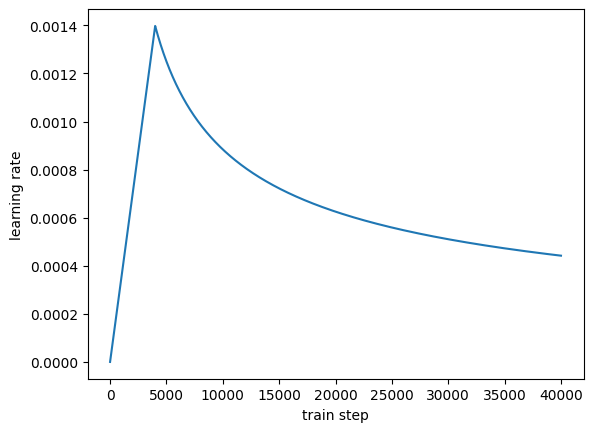

In [ ]:
# instantiate the Adam optimizer
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)
# test the custom learning rate scheduler
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.xlabel('train step'); plt.ylabel('learning rate')

*Set up the loss and metrics.* Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [ ]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')
  loss = loss_object(label, pred)
  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred
  mask = label != 0
  match = match & mask
  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

*Train the model.* Configure the training procedure and run it.

In [ ]:
transformer.compile(loss=masked_loss, optimizer=optimizer, metrics=[masked_accuracy])
transformer.fit(train_ds, epochs=1, validation_data=val_ds) # GPU 20ep 1hr

810/810 [==============================] - 210s 217ms/step - loss: 6.4607 - masked_accuracy: 0.1522 - val_loss: 4.7657 - val_masked_accuracy: 0.2661


### Run inference
For efficient training, the model predicts next token for each token in the output sequence simultaneously. This is redundant during inference, and only the last prediction is used.
* Encode the input sentence using the context tokenizer. This is the encoder input.
* The decoder input is initialized to the [START] token.
* Calculate the padding masks and the look ahead masks.
* The decoder then outputs the predictions by looking at the encoder output and its own output (self-attention).
* Concatenate the predicted token to the decoder input and pass it to the decoder.
* The decoder predicts the next token based on the previous tokens it predicted.

Define the Translator class by subclassing tf.Module.

In [ ]:
class Translator(tf.Module):
  def __init__(self, ctx_tokenizer, trg_tokenizer, transformer):
    self.ctx_tokenizer = ctx_tokenizer
    self.trg_tokenizer = trg_tokenizer
    self.transformer = transformer
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=trg_tokenizer.get_vocabulary(),
        mask_token='', oov_token='[UNK]', invert=True)

  def __call__(self, sentence, max_length=max_tokens):
    # the input sentence has [START] and [END] tokens
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape)==0: sentence = sentence[tf.newaxis]
    sentence = self.ctx_tokenizer(sentence).to_tensor()
    encoder_input = sentence
    # initialize the output with English [START] token
    start_end = self.trg_tokenizer([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]
    # tf.TensorArray is required instead of Python list, so that
    # dynamic-loop can be traced by tf.function
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)
      # select the last token from the seq_len dimension
      predictions = predictions[:, -1:, :] # shape (batch_size, 1, vocab_size)
      predicted_id = tf.argmax(predictions, axis=-1)
      # concatenate predicted-id to output which is given to decoder as input
      output_array = output_array.write(i+1, predicted_id[0])
      if predicted_id == end: break

    output = tf.transpose(output_array.stack()) # shape (1, tokens)
    tokens = self.id_to_word(output)
    text = tf.strings.reduce_join(tokens, axis=-1, separator=' ') # shape ()
    text = tf.strings.regex_replace(text, '^ *\[START\] *', '')
    text = tf.strings.regex_replace(text, ' *\[END\] *$', '')
    # tf.function prevents us from using the attention_weights that were calculated
    # in the last iteration of the loop, so recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores
    return text, tokens, attention_weights

Note: This function uses an unrolled loop, it generates max_tokens on every call. Refer to [NMT with attention](nmt_with_attention.ipynb) for implementation with a dynamic loop, which can be much more efficient. Create an instance of this Translator class.

In [ ]:
translator = Translator(context_text_processor, target_text_processor, transformer)

def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction:":15s}: {tokens.numpy()}')
  print(f'{"Ground truth:":15s}: {ground_truth}')

In [ ]:
# Example
sentence = 'muy bien'; ground_truth = "very good"
translated_text, translated_tokens, attention_weights = translator(tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

### Create attention plots
The Translator class returns a dictionary of attention heatmaps you can use to visualize the internal working of the model. Create a function that plots the attention when a token is generated.

In [ ]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # the model didn't generate [START] in the output, skip it
  translated_tokens = translated_tokens[1:]
  ax = plt.gca(); ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens))); ax.set_yticks(range(len(translated_tokens)))
  labels = [label for label in in_tokens]
  ax.set_xticklabels(labels, rotation=90)
  labels = [label for label in translated_tokens]
  ax.set_yticklabels(labels)

In [ ]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf_lower_and_split_punct(sentence)
  in_tokens = in_tokens.numpy().decode().split()
  fig = plt.figure(figsize=(16,8))
  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)
    plot_attention_head(in_tokens, translated_tokens, head)
    ax.set_xlabel(f'Head {h+1}')
  plt.tight_layout(); plt.show()

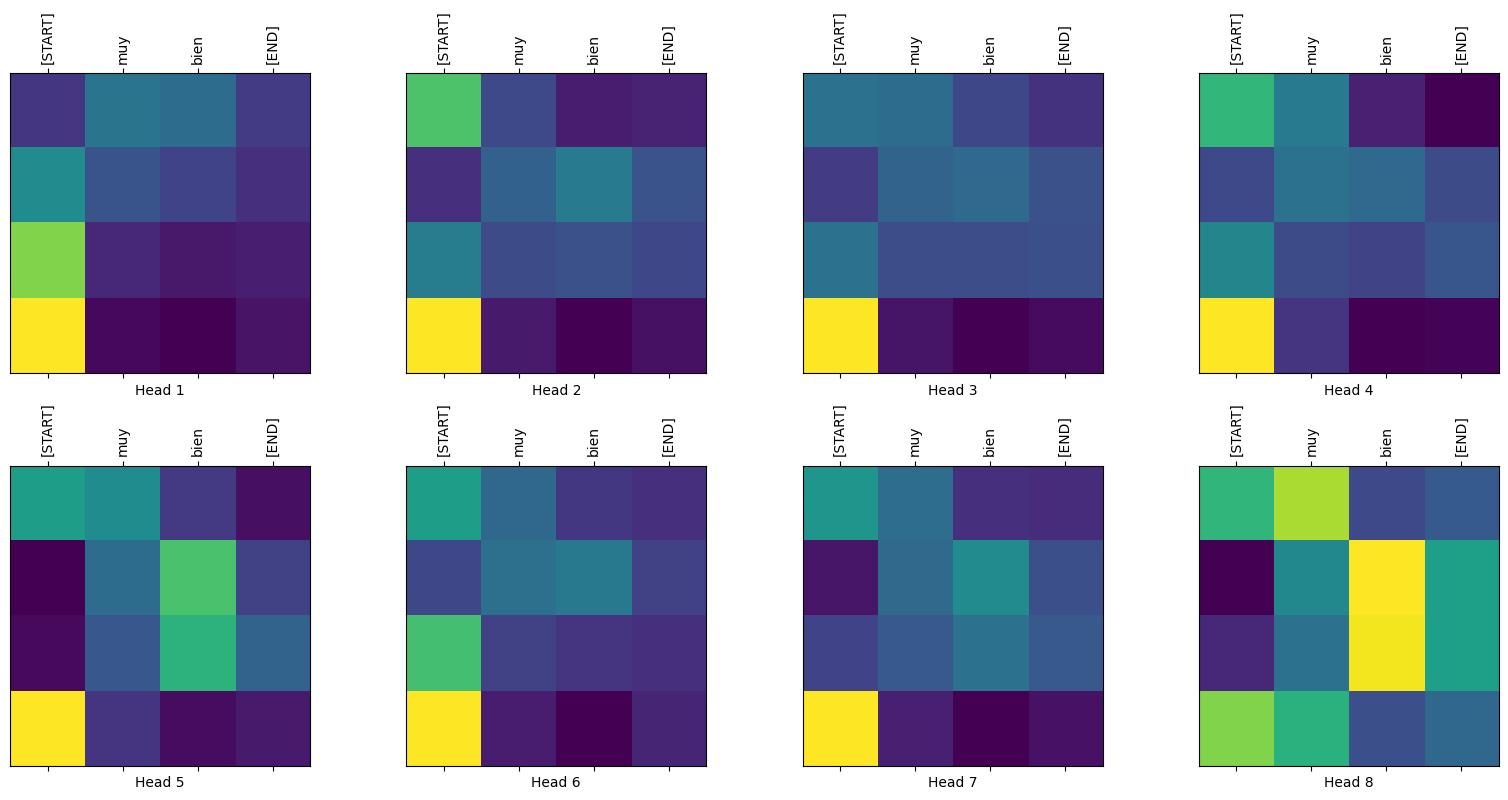

In [ ]:
head = 0; attention_heads = tf.squeeze(attention_weights, 0)
attention = attention_heads[head]; attention.shape
# shape (batch_size, num_heads, seq_len_q, seq_len_k)
plot_attention_weights(sentence, translated_tokens, attention_weights[0])

### Export the model
Create a class ExportTranslator by subclassing tf.Module subclass with a tf.function on the call method.

In [ ]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result, tokens, attention_weights) = self.translator(sentence, max_length=max_tokens)
    return result

In [ ]:
translator = ExportTranslator(translator)  # wrap translator in this class
tf.saved_model.save(translator, export_dir='translator')
reloaded = tf.saved_model.load('translator')
reloaded(sentence).numpy()

### Conclusion
For time-series, the output for a time-step is calculated from the entire history instead of only the inputs and the current hidden state, this may be less efficient. There are a wide variety of Transformer-based models with encoder-decoder, encoder-only and decoder-only architectures. Some of these models are covered in the following research publications:

* ["Efficient Transformers: a survey"](https://arxiv.org/abs/2009.06732) (Tay et al., 2022)
* ["Formal algorithms for Transformers"](https://arxiv.org/abs/2207.09238) (Phuong and Hutter, 2022)
* [T5 ("Exploring the limits of transfer learning with a unified text-to-text Transformer")](https://arxiv.org/abs/1910.10683) (Raffel et al., 2019)

You can learn more about other models in the following Google blog posts:

* [PaLM](https://ai.googleblog.com/2022/04/pathways-language-model-palm-scaling-to.html)
* [LaMDA](https://ai.googleblog.com/2022/01/lamda-towards-safe-grounded-and-high.html)
* [MUM](https://blog.google/products/search/introducing-mum/)
* [Reformer](https://ai.googleblog.com/2020/01/reformer-efficient-transformer.html)
* [BERT](https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html)

If you're interested in studying how attention-based models have been applied in tasks outside of natural language processing, check out the following resources:

- Vision Transformer (ViT): [Transformers for image recognition at scale](https://ai.googleblog.com/2020/12/transformers-for-image-recognition-at.html)
- [Multi-task multitrack music transcription (MT3)](https://magenta.tensorflow.org/transcription-with-transformers) with a Transformer
- [Code generation with AlphaCode](https://www.deepmind.com/blog/competitive-programming-with-alphacode)
- [Reinforcement learning with multi-game decision Transformers](https://ai.googleblog.com/2022/07/training-generalist-agents-with-multi.html)
- [Protein structure prediction with AlphaFold](https://www.nature.com/articles/s41586-021-03819-2)
- [OptFormer: Towards universal hyperparameter optimization with Transformers](http://ai.googleblog.com/2022/08/optformer-towards-universal.html)
